# One machine sequencing problem

In [1]:
import networkx as nx               # network graph manipulation


from networkx.drawing.nx_pydot import graphviz_layout


import pandas as pd                 # data mnipulation
import numpy as np                  # ----------------

import matplotlib.pyplot as plt     # show graphics
from matplotlib.patches import Patch
import plotly.express as px         # -------------
import matplotlib.cm as cm

import math                         # mathematics tools

from time import time               # evaluate the the performance of the algorithms

import docx
from docx.shared import Inches

from pulp import *

from scipy.stats import randint

## Programmation of the node Class

Throughout the programming of the class, we will test our functions as we go along using the test instance that is given in the topic. We will focus on test instance generation afterwards.

### Main structure

In [2]:
class Node :
    '''
    definition of the attributes of the class
    '''

    def __init__ (self , N , a , d , q) :

        #   attributs to stock the data

        self._N = []
        self._a = {}
        self._d = {}
        self._q = {}

        k = 0

        for i in N :

            self._N.append(i)
            self._a[i] = a[k]
            self._q[i] = q[k]
            self._d[i] = d[k]

            k+=1


        # local lower bound
        self._LB = -math.inf

        #   attribut to link the nodes in a tree.
        self._parent = None
        self._children = []

        # attributs to construct the branch and bound tree
        self._update_sol = False
        self._order = -1             
        self._edge = 0
        self._level = 1

In [3]:
''' 
Beware the different set have to be sorted with respect to N
'''

N = list(range(1,8))
a = [10,13,11,20,30,0,30]
d = [5,6,7,4,3,6,2]
q = [7,26,24,21,8,17,0]

e = Node(N,a,d,q)

#### Print a Node 

In [4]:
def _to_string(self) :

  '''
  Print the tasks
  '''

  # Creation of a dictionary of tasks 
  #   - key: the number of the task, 
  #   - values: the value of a, d and q for this task
  dict_tasks = {}

  for i in self._N :
    list_task = []
    list_task.append(self._a[i])
    list_task.append(self._d[i])
    list_task.append(self._q[i])
    dict_tasks["task "+str(i)] = list_task
    
  # Placement in a dataframe
  df_tasks = pd.DataFrame(dict_tasks)
  df_tasks.index = ["a", "d", "q"]
  print(pd.DataFrame(df_tasks))


setattr(Node , "_to_string" , _to_string)
e._to_string()

   task 1  task 2  task 3  task 4  task 5  task 6  task 7
a      10      13      11      20      30       0      30
d       5       6       7       4       3       6       2
q       7      26      24      21       8      17       0


#### The conjunctive graph

The conjunction graph is a tool that will allow us to represent the problem. It will be constituted in the following way (for two spots in our graph):

<img src="conjunctive _graph.png" width="500">

This graph has a particular topology that it will be interesting to exploit later.

In [5]:
def _construct_conjonctive (self , schedule):
    ''' 
    output : the conjonctive graph for a given schedule
    '''

    # construction of a directed graph :
    G = nx.DiGraph() 

    # construction of the submit :

    sbm = ['s','t']+schedule
    G.add_nodes_from(sbm)

    # construction of the edges.
    # shcedule --> permutation of element of self._N


    for i in range(len(schedule)) :

        curr = schedule[i]
        
        e1 = ("s",curr , self._a[curr])
        e2 = (curr,"t",self._q[curr]+self._d[curr])
        # we check if we are at the last task of the schedule
        if i != len(schedule)-1 :
            next = schedule[i+1]
            e3 = (curr,next,self._d[curr]) # creation of the last edges.
            G.add_weighted_edges_from([e1,e2,e3])
        else :
            G.add_weighted_edges_from([e1,e2])
    
    # we return the conjunctive graph.
    return(G)

setattr(Node , "_construct_conjonctive" , _construct_conjonctive)



In [6]:
def _print_graph(self , schedule , path ,Larg , Haut) :
    
    G = self._construct_conjonctive(schedule)

    # color of the edges
    for (u,v) in G.edges():
        G[u][v]['color'] = 'grey'

    for k in range(len(path)) :
        curr = path[k] # current note
        if k==0 and len(path)>1:
            next = path[k+1]
            G['s'][curr]['color'] = 'red'
            G[curr][next]['color'] = 'red'

        elif k == len(path)-1 :
            if len(path)==1 :
                
                G['s'][path[0]]['color'] = 'red'
                G[path[0]]['t']['color'] = 'red'
            else :
                G[curr]['t']['color'] = 'red'

        else :
            
            next = path[k+1]
            G[curr][next]['color'] = 'red'

    colors = [G[u][v]['color'] for u,v in G.edges()]
    weights = [G[u][v]['weight'] for u,v in G.edges()]

    # color of the nodes
    couleurs_sommets = ["yellow"] * G.number_of_nodes()   


    pos = {} # positions of the node.
    
    set_x = 0
    set_y = len(schedule)/2
    dy = -1

    
    for t in schedule : 
        pos[t] = [set_x , set_y]
        set_y += dy

    # position of the sources nodes.
    pos['s'] = [-1 , 0]
    pos['t'] = [1, 0]


    options = {
    'node_color' : couleurs_sommets,
    'node_size'  : 550,
    'pos' : pos,
    'edge_color' : colors,
    'with_labels': True,
    }

    fig = plt.figure(figsize=(Larg,Haut))
    nx.draw(G,**options)
    labels = nx.get_edge_attributes(G,'weight')


    nx.draw_networkx_edge_labels(G,edge_labels = labels,pos = pos)
    # title of the print
    plt.title("Conjunctive graph associate with : {}".format(schedule))
    plt.show()

setattr(Node , "_print_graph" , _print_graph)

In [7]:
def _graph_ready_to_print(self , schedule , path ) :
    '''
    same function but return a matplotlib object ready to print.
    '''
    
    G = self._construct_conjonctive(schedule)

    # color of the edges
    for (u,v) in G.edges():
        G[u][v]['color'] = 'grey'

    for k in range(len(path)) :
        curr = path[k] # current note
        if k==0 and len(path)>1:
            next = path[k+1]
            G['s'][curr]['color'] = 'red'
            G[curr][next]['color'] = 'red'

        elif k == len(path)-1 :
            if len(path)==1 :
                
                G['s'][path[0]]['color'] = 'red'
                G[path[0]]['t']['color'] = 'red'
            else :
                G[curr]['t']['color'] = 'red'

        else :

            next = path[k+1]
            G[curr][next]['color'] = 'red'

    colors = [G[u][v]['color'] for u,v in G.edges()]
    weights = [G[u][v]['weight'] for u,v in G.edges()]

    # color of the nodes
    couleurs_sommets = ["yellow"] * G.number_of_nodes()   


    pos = {} # positions of the node.
    
    set_x = 0
    set_y = len(schedule)/2
    dy = -1

    
    for t in schedule : 
        pos[t] = [set_x , set_y]
        set_y += dy

    # position of the sources nodes.
    pos['s'] = [-1 , 0]
    pos['t'] = [1, 0]


    options = {
    'node_color' : couleurs_sommets,
    'node_size'  : 550,
    'pos' : pos,
    'edge_color' : colors,
    'with_labels': True,
    }

    
    labels = nx.get_edge_attributes(G,'weight')

    return G , options , labels , pos

setattr(Node , "_graph_ready_to_print" , _graph_ready_to_print)

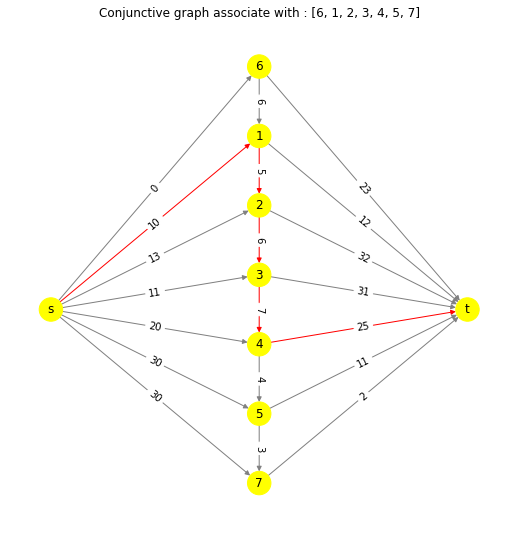

In [8]:
tab = [6, 1, 2, 3, 4, 5, 7] # schedule of the subject
e._print_graph(tab , [1, 2, 3, 4] ,7,7) # print of the schedule.

#### The longest path

Our objective is now to search in the conjunctive graph, for a given node and a given schedule $(T_1 , \dots , T_{|N|})$ the longest path between $s$ and $t$. Indeed in this problem the longest path between s and t will give us exactly the time that the programming that corresponds to the graph will cost in terms of time, a search for the longest path is thus a way to obtain this cost in an optimized way.

We know that the search of the longest path, between two nodes in a graph is the same (in terms of time complexity) than search the longest path, between the node s and all the node in the graph. Because of the particular topology of the graph, the search of the longest in this graph will be proceed as follows :

* First we can easily calculate the longest path between $s$ and $T_1$ wich is the first task in our schedule (corresponds to 6 in the above graph). This is $a_{T_1}$.

* The by recursion, lets suppose that for the task $T_k$, we know the value of the longest path and it is $L_k$. Then we are in the follonwing situation :

<img src="longest_path_expl.png" width="700">

Then we have necessarly (because of the topology of the graph):
$$
\boxed{L_{k+1} = \max(a_{k+1},L_{k}+d_{k})}
$$

* Now that we have all the distance $L_k$, we can also calculate the longest path to $t$ as :

$$
\boxed{L_t = \max _{k \in \{1,\dots,|N|\}}(L_k + d_k+q_k)}
$$

The complexity of this algorithm will be just $\mathcal{O}(|N|)$, where $|N|$ is the number of task in the schedule, indeed in a signle loop trough the task we can easily calculate the different quantity above .


**note :** In this programming, the longest path must have a particular property. It will obviously have to be the longest in terms of cost, but it will also have to pass through the most tasks possible. In this way we will be able to have more possibilities to find the so-called critical tasks (notion that we will detail later).
We will thus work with broad, rather than strict, inequalities



In [9]:
def _longest_path(self, schedule):
    
    '''
    output : python dictionnary
        - value : the length of the longest past
        - path : the tasks of N in the path.
    '''

    L = {}      # dictionnary that will contain the distances
    pred = {}   # dictionnary that will contain the predecessors


    # 1 : initiation of the values
    L['s'] = 0
    pred['s'] = 's'

    L['t'] = -math.inf

    
    for k in schedule :
        L[k] = self._a[k]
        pred[k] = 's'

    # 2 : propagation of the solution :

    for i in range(len(schedule)) :

        curr = schedule[i]                  #    current node to treat.
                                            #    we'll check the succesors of curr 
        if i != len(schedule)-1 :

            next = schedule[i+1]            # next node in the order.
            new_L = L[curr]+self._d[curr]

            if (new_L >= L[next]) :
                L[next] = new_L
                pred[next] = curr
        
                                            # we'll change the value of the path to t
                                            # from the current node.
                                            
        new_t = L[curr]+self._d[curr]+self._q[curr]

        if new_t >= L['t'] :
            pred['t'] = curr
            L['t'] = new_t

    
    # backpropagation to find the path
    temp = 't'
    makespan = L['t']
    path = ['t']


    while temp !='s':

        path.insert(0,pred[temp]) # add to the begining
        temp = pred[temp]

    path.pop()
    path.pop(0)
    

    res = {'value' : makespan , 'path' : path}


    
    return(res)


setattr(Node , "_longest_path" , _longest_path)

In [10]:
e._longest_path(tab)

{'value': 53, 'path': [1, 2, 3, 4]}

#### Work on the Schrage schedule

The Schrage schedule is the hearth of this part. It is an heuristic that allows us to choose a task scheduling.
Elle se trouve de la manière suivante :

Let $U$ be the programming called schrage and let $\bar{U}$ be the set of our tasks

* step 1 : initialization $U = emptyset$ and $\bar{U}$ the set of our tasks, and $t = \min_{i \in \bar{U}} a_i$.

* step 2 : At time t, we consider $i \in \bar{U}$, such that $a_i \leq t$ and $i \in argmax_{j \in \bar{U}} q_j$.

* step 3 : $U = U\cup \{i\}$, $\bar{U} = \bar{U \backslash\{i\}}$, then $t_i = t$ and $t = \max (t_i + d_i + \min_{i \in \bar{U}} a_i)$

If arrived in three we have that $|U| \neq |N|$, then we return in stage 2


In [11]:
def _schrage_schedule(self) :
        #       Step 1
        n = len(self._N)
        U = []
        b_U = self._N.copy() #  Copy of all the tasks
        t = min([self._a[i] for i in b_U])

        #       step 2 and 3
        while (len(U) != n) :
                arg_set = []                        # set where we search for the argmax
                for j in b_U :
                        if self._a[j] <= t :
                                arg_set.append(j)

                buff = [self._q[j] for j in arg_set]

                idx_arg_max = np.argmax(buff)
                i = arg_set[idx_arg_max]

                b_U.remove(i)
                U.append(i)

                ti = t
                buff = [self._a[j] for j in b_U]


                '''
                two cases : --> b_U is empty 
                '''
                if len(b_U)==0 :
                        t = ti + self._d[i]
                else :
                        t = max(ti + self._d[i] , min([self._a[i] for i in b_U]))

        return U

setattr(Node , "_schrage_schedule" , _schrage_schedule)

In [12]:
e._schrage_schedule()

[6, 1, 2, 3, 4, 5, 7]

#### Critical search

In [13]:
def _critical_search(self,schedule) :

    '''
    input : python array
        - the array is a permutation of the set self._N

    output : python dictionnary
        - makespan : time of the schedule
        - J : critical set (if it exists)
        - jc : critical task (if it exists)
        - status : status of the schrage schedule
    '''
    
    output = self._longest_path(schedule) # search for the longest path
    path = output['path']                 # get the path
    makespan = output['value']            # time that the schedule will take


    jp = path[-1]           # last task to worry about
    target = self._q[jp]
    J = [jp]                # critical set
    jc = -1                 # critical task
    status = ''             # status of the schedule.

    # search of a potential critical task  --> we search from the end to the begining of the path.
    # the critical set will grow wathever happens.

    for i in range(len(path)-2 , -1 , -1) :

        jk = path[i]
        buff = self._q[jk]

        if (buff<target) :
            # critical set found, we stop.
            jc = jk
            break
        else :
            J.append(jk)

    
    if(jc == -1):
        # critical task not found --> schedule is optimal
        #                         --> the critical set doesn't exists
        J = []
        status = 'optimal'
    else :
        status = 'not_optimal'

    
    # dictionnary to return
    res = {'makespan' : makespan , 'J' : J , 'jc' : jc , 'status' : status}

    return(res)

setattr(Node,"_critical_search",_critical_search)

In [14]:
e._critical_search(tab)

{'makespan': 53, 'J': [4, 3, 2], 'jc': 1, 'status': 'not_optimal'}

In [15]:
def _lower_bound(self , I) :

    s1 = min([self._a[i] for i in I])
    s2 = sum([self._d[i] for i in I])

    s3 = min([self._q[i] for i in I])

    return(s1+s2+s3)

setattr(Node,"_lower_bound",_lower_bound)

#### Creation of the nodes

In [16]:
def _nodes_creation(self , J , jc):

    ''' 
    output : python array
        - the first node is the node where we changed the value of q
        - the second node is the node where we changed the value of a
    '''
    jp = J[0]

    q_jc = sum([self._d[r] for r in J]) + self._q[jp]
    a_jc = min([self._a[r] for r in J]) + sum([self._d[r] for r in J])

    N = self._N.copy()

    a1 = []
    a2 = []

    d1 = []
    d2 = []

    q1 = []
    q2 = []

    for i in N :
        a1.append(self._a[i])
        a2.append(self._a[i])
        d1.append(self._d[i])
        d2.append(self._d[i])
        q1.append(self._q[i])
        q2.append(self._q[i])

    e1 = Node(N , a1 , d1 , q1)
    e2 = Node(N , a2 , d2 , q2)


    e1._q[jc] = q_jc
    e1._edge = q_jc


    e2._a[jc] = a_jc
    e2._edge = a_jc

    return([e1,e2])
setattr(Node,"_nodes_creation",_nodes_creation)

### Branch and bound algorithm

In [17]:
def search_current_index(Queue,Tree) :
    '''
    objectiv : search of the node not treated with the highest lower bound

    input : Queue --> list of index (index of the nodes not treated in the Tree)
            Tree  --> list of nodes

    output : index of the node with the highest lower bound in the tree (not treated)
    '''

    res = Queue[0]
    LB = Tree[res]._LB

    for idx in Queue :

        if Tree[idx]._LB>LB :

            res = idx
            LB = Tree[res]._LB

    return res

In [18]:
def branch_n_bound(N , a , d , q , msg = 0) :

    Tree = []       # list of all nodes created (a list of Node objects)
    Queue = []      # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    UB = math.inf   # set the upper bound to a sufficiently large number
                    
    incumbent = []  # initialize the incumbent solution

    root = Node(N , a , d , q)      # at the root node no variables are fixed

    Tree.append(root)               # start the tree with the root node
    Queue.append(0)

    LB = root._lower_bound(N)
    root._LB = LB

    
    order = 0

    while (Queue!=[] and np.abs(UB-LB)>=1) :                     #   while there is nodes to treat :
        
        currentindex = Queue[0]             # note that we follow a first-in-first-out node processing strategy
        currentnode = Tree[currentindex]

        #   evaluation step :
        shr_schedule = currentnode._schrage_schedule()
        output = currentnode._critical_search(shr_schedule)
        currentUB = output['makespan']
        currentLB = currentnode._LB

        # order of the nodes in th branch and bound --> construction of the tree
        currentnode._order = order
        order += 1

        #   --> update of the upper bound
        #   --> update of the current solution

        if currentUB < UB :
            UB = currentUB
            incumbent = shr_schedule
            currentnode._update_sol = True  # this node made the current solution better

        
        
        if (output['status']=='not_optimal') :
            #   creation of the nodes
            e1 , e2 = currentnode._nodes_creation(output['J'],output['jc'])

            # update of the relationships
            e1._parent = currentnode
            e2._parent = currentnode
            currentnode._children = [e1,e2]

            e1._level = currentnode._level +1
            e2._level = currentnode._level +1


            #   update of the local lower bound
            e1._LB = max(currentLB , e1._lower_bound(output['J']) , e1._lower_bound(output['J']+[output['jc']] ))
            e2._LB = max(currentLB , e2._lower_bound(output['J']) , e2._lower_bound(output['J']+[output['jc']] ))
            
            
            # update of the tree and the queue
            Queue.append(len(Tree))
            Queue.append(len(Tree)+1)

            Tree.append(e1)
            Tree.append(e2)
               

        
        LB = min([Tree[n]._LB for n in Queue]) # global lower
        Queue.remove(currentindex)


        
    return {'UB' : UB , 'LB' : LB , 'SCHD': incumbent , 'Tree' : Tree}

    

In [19]:
def construct_tree(Tree) :
    '''
    Construction of the branch and bound tree and print of it
    '''
    bb_tree = nx.DiGraph()
    colors = [0]*len(Tree)
    nx.set_node_attributes(bb_tree, 'colors', colors)

    nd_not_treated = len(Tree)-1

    Queue = [Tree[0]]
    bb_tree.add_node(Tree[0]._order)
    marked = [Tree[0]]                  # Nodes of the bb_tree treated

    colors = []
    while (Queue != []) :

        buff = Queue.pop(0)             # we take the first

        # order = -1 the node wasn't treated.
        if (buff not in marked):
            bb_tree.add_node(buff._order)
            marked.append(buff)

        if (len(buff._children) != 0) :
            Queue += buff._children     # we add the children

            for n in buff._children :
                if (n not in marked) :
                    if n._order == -1 :
                        bb_tree.add_node(nd_not_treated)
                        bb_tree.add_weighted_edges_from([(buff._order , nd_not_treated , n._edge)])
                        marked.append(n)
                        nd_not_treated+=1
                    else :
                        bb_tree.add_node(n._order)
                        bb_tree.add_weighted_edges_from([(buff._order , n._order , n._edge)])
                        marked.append(n)

    
    return bb_tree
            
        
        

    

In [20]:
def bb_tree_ready_to_print(Tree , Larg = 7 , Haut = 7):


    G = construct_tree(Tree)
    pos = graphviz_layout(G, prog="dot")
    nds = G.nodes()
    colors = []
    
    nd_max = len(Tree)-1

    node_not_treated = []

    for t in Tree :
        if t._order == -1 :
            node_not_treated.append(nd_max)
            nd_max += 1

    for n in nds :
        if n in node_not_treated :
            colors.append('red')
        else :
            for t in Tree :
                if n==t._order :
                    if t._update_sol :
                        colors.append('green')
                    else :
                        colors.append('grey')

    
    options = {
    'node_color' :  colors,
    'node_size'  : 550,
    'pos' : pos,
    'with_labels': True,
    }
    
    return G , options


In [21]:
def solve_schrage_heuristic(N,a,d,q , show_output = True ,graphics = True , larg = 7 , haut = 7):

    r = Node(N,a,d,q)

    # solve the problem with the schrage heuristic

    start = time()
    solution = branch_n_bound(N , a , d , q)
    end = time()-start

    if show_output :
        
        print("--- Solution of the one machine sequencing problem ---")
        print()
        print("optimal value : ",solution['UB'])
        print("schedule : ",solution['SCHD'])
        print("running time : ",end)
        print()
    

    G=nx.grid_2d_graph(1,2)  #1x2 grid
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(4*larg,2*haut))

    # the conjunctive graph
    lg_path = r._longest_path(solution['SCHD'])['path']
    G , options , labels , pos = r._graph_ready_to_print(solution['SCHD'] , lg_path )
    labels = nx.get_edge_attributes(G,'weight')        

    plt.subplot(121)
    nx.draw(G,**options)
    nx.draw_networkx_edge_labels(G,edge_labels = labels,pos = pos)
    plt.title("the solution")
    
    
    G , options = bb_tree_ready_to_print(solution['Tree'])
    lvl = max([t._level for t in solution['Tree']])
    pos = options['pos']
    labels = nx.get_edge_attributes(G,'weight')
    
    plt.subplot(122)
    nx.draw(G,**options)
    nx.draw_networkx_edge_labels(G,edge_labels = labels,pos = pos)
    plt.title('the branching tree of level : {}'.format(lvl))


    solution['time'] = end

    if graphics :
        plt.show()
        return solution
    else :
        return solution,fig

--- Solution of the one machine sequencing problem ---

optimal value :  50
schedule :  [6, 3, 2, 4, 1, 5, 7]
running time :  0.001695871353149414



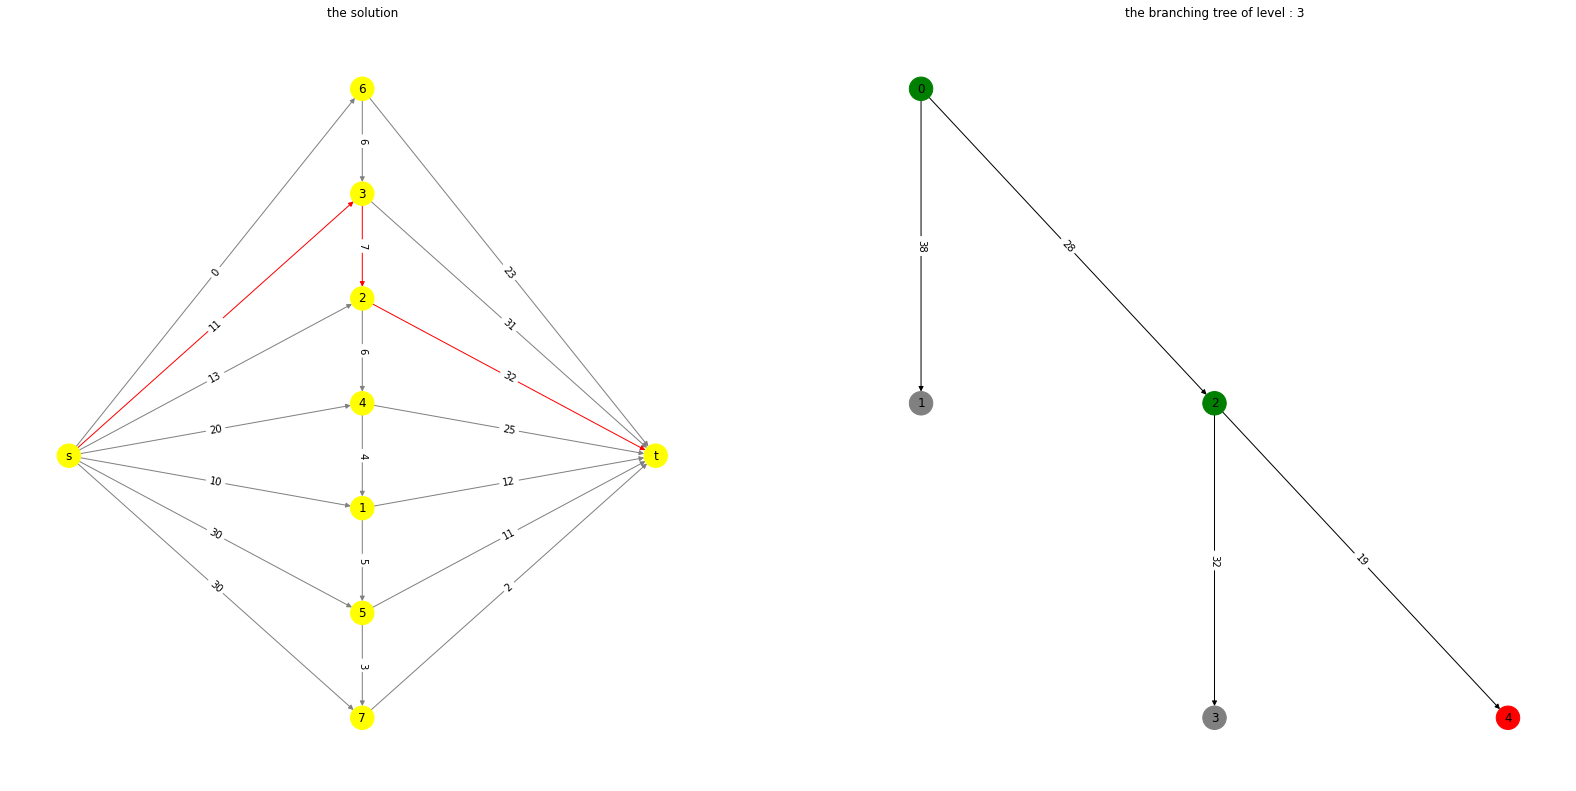

In [22]:
N = list(range(1,8))
a = [10,13,11,20,30,0,30]
d = [5,6,7,4,3,6,2]
q = [7,26,24,21,8,17,0]


solution = solve_schrage_heuristic(N,a,d,q)

## The Pulp model

In [23]:
def instance_creation(N,a,d,q) :
  _N = []
  _a = {}
  _d = {}
  _q = {}

  k = 0

  for i in N :

    _N.append(i)
    _a[i] = a[k]
    _q[i] = q[k]
    _d[i] = d[k]

    k+=1

  return _N , _a, _d , _q

### Definition of the model

The objective in this part is to define a pulp linear model, which represent the model.

To define a linear model we have to :

**Define the variable of the problem** : 
* $t_i~~~~~~i ~~~~\in \{1,\dots,|N|\}$ will represent the time where the task $i$ starts to be proceeded
* $x_{i,j}~~~i,j \in  \{1,\dots,|N|\} $ will be binary variable and $x_{i,j} = 1$ says that the task $j$ is proceeded before the task $i$
* $z$ which is the time that the schedule takes (total time)

**Define the objectiv of the problem** :

$$
\boxed{\min z}
$$


**Define the constraints of the problem** :

First, we have constraints on the binary variables x. Indeed we want these variables to represent an order. So we have :

* total order constraints:
$$
\boxed{x_{i,j} + x_{j,i} = 1~~~~\forall i<j \in \{1,\dots,|N|\}}
$$

* transitivity constraints:
$$
\boxed{x_{i,k} + x_{k,j} \leq x_{i,j}+1~~~~\forall k, i<j \in \{1,\dots,|N|\}}
$$

We then have constraints that are called business constraints, because they are directly related to the problem:

* we want all jobs, to start after the waiting date:
$$
\boxed{t_i \geq a_i~~~~\forall i \in \{1,\dots,|N|\}}
$$

* Then we want that if a task starts before another one, then the time at which this task starts, is smaller than the time at which the other task starts. This can be put in the following form:

$$
\boxed{t_i < t_j \iff x_{i,j} = 1 ~~~~ \forall i<j\in \{1,\dots,|N|\}}\iff \boxed{t_j \geq d_i + t_i - M(1-x_{i,j})~~~\text{and}~~~~ t_j \leq t_i+d_i -1 -Mx_{i,j}~~~~~}
$$

* we then want our variable z to represent the objective value of our problem, so we have :

$$
\boxed{z \geq t_i + d_i + q_i ~~~~ \forall i \in \{1,\dots,|N|\}}
$$

* we then have constraints on the spaces where our variables live:

$$
\boxed{x_{i,j} \in \{0,1\}~~ \forall i,j\in \{1,\dots,|N|\}~~~~t_i \in \mathbb{N}~~ \forall i \in \{1,\dots,|N|\}~~~~z \in \mathbb{N}}
$$





In [24]:
def pulp_model(N,a,d,q):
  '''
  input  : N,a,d,q --> values of the one machine sequencing problem.

  output : model   --> pulp model of the problem.
  '''

  # definition of the problem --> minimization 
  model = LpProblem("one_machine",LpMinimize)


  up_b = sum([a[i]+d[i]+q[i] for i in N]) # this is the value of the worst solution

  # variables défnition
  x = LpVariable.dicts("x", (N,N), 0, 1, LpInteger)
  t = LpVariable.dicts("t" , N ,0,up_b, LpContinuous)
  z = LpVariable("z" ,0,up_b,LpInteger)

  # objective
  model += z

  # constraints definition


  # --> constraint about the objectif (linearization of a maximum)
  for i in N :
    model += z >= t[i]+d[i]+q[i]      

  # --> constraints about the order
  for i in N :

    for j in N :

      if (i<j) :
        # total order constraint
        model += x[i][j] + x[j][i] == 1  
      
      for k in N :
        # transitivity constraint
        model += x[i][k] + x[k][j] <= x[i][j] + 1
      
  

  # --> constraints about the machine
  M = up_b

  for i in N :
    model += t[i]>= a[i]                          # note starting before the start time
    for j in N :
      model += t[j] >= d[i]+t[i] - M*(1-x[i][j])   # constraints between the jobs (i before j)
      model += t[j]-t[i] <= d[i] - 1 + M*(x[i][j])

  return model


### Solving the model

In [25]:
def solve_pulp_model(N,a,d,q , show_output = True):

  N,a,d,q = instance_creation(N,a,d,q)

  start = time()
  model = pulp_model(N,a,d,q)                    # the model
  end_time = time()-start
  model.solve(COIN_CMD(msg=0 , mip=1)) # solve the model

  if (LpStatus[model.status]=="Optimal"):

    # the solution :
    varsdict = {} # contain the variables

    for v in model.variables():
      if("t_" in v.name) :
        varsdict[v.name] = v.varValue
    
    t = {k: v for k, v in sorted(varsdict.items(), key=lambda item: item[1])} # sort of the dictionnary (by values)

    schedule = [int(k.replace('t_', '')) for k in t]

    if show_output :

      print("Running time : ",end_time)
      print("Solution value : ",value(model.objective))
      print("MIP schedule : ",schedule)

    return {"SCHD" : schedule , "OBJ" : value(model.objective) , "RUN_TIME" : end_time}

  else :
    # problem not solved
    print("error : problem not solved")

## Instances generations

What is now important is to generate test instances, which will pose problems to our different solvers (schrage and MIP). First of all, we can notice that each spot is nothing else than a point in a 3D space. Indeed for each spot, we have three values $a$ , $d$ and $q$.

### Visualize the tasks in 3D

In [26]:
def visu_tasks(N,a,d,q):
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")

    # Creating plot
    ax.scatter3D(a, d, q, color = "green")
    plt.title("Task simulated")
    
    return fig

### Task on a circle

In [27]:
def sample_spherical(npoints, radius=1 , origin = [0,0,0]) :

    vec = np.random.randn(3, npoints)

    vec /= np.linalg.norm(vec, axis=0)

    vec *= radius

    return np.array(vec[0])+origin[0], np.array(vec[1])+origin[1] , np.array(vec[2])+origin[2]


def instance_in_circle(num_task,origin , radius) :

    if origin[0]**2 + origin[1]**2+origin[2]**2 > radius**2 :

        a , d ,q = sample_spherical(num_task , radius , origin)

        a = a.astype(int)
        d = d.astype(int)
        q = q.astype(int)

        return list(range(len(a))),list(a),list(d),list(q)
    else : 
        print("impossible")
        return None

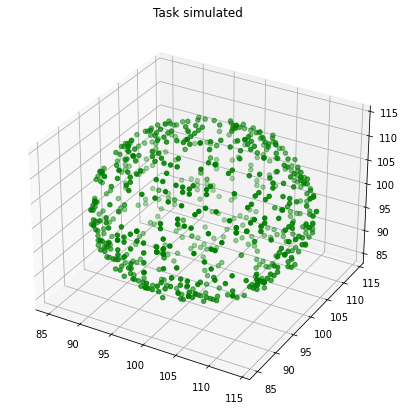

In [28]:
N,a,d,q = instance_in_circle(700 , radius = 15 , origin = [100,100,100])

fig = visu_tasks(N,a,d,q)

### Just randoms tasks

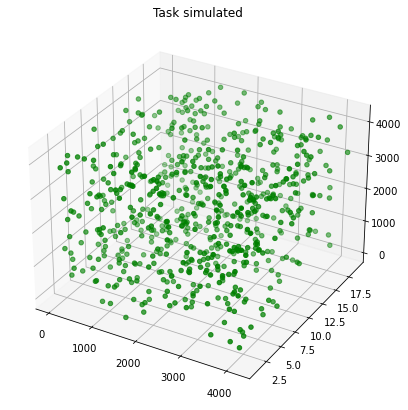

In [29]:
def random_instance_default(n , m , K):
    '''
    produce a random instance
    '''

    N = list(range(1,n+1))

    amax = int(1/50*m*n*K)
    qmax = int(amax)
    dmax = int(m) 

    a = randint.rvs(1 , amax ,size=  n)
    d = randint.rvs(1 ,dmax , size = n)
    q = randint.rvs(1 ,qmax , size = n)

    return N, a , d , q

N,a,d,q = random_instance_default(700 , 20 , 15)

fig = visu_tasks(N,a,d,q)
    

## Visualization and representation of solutions 

### Produce a calender

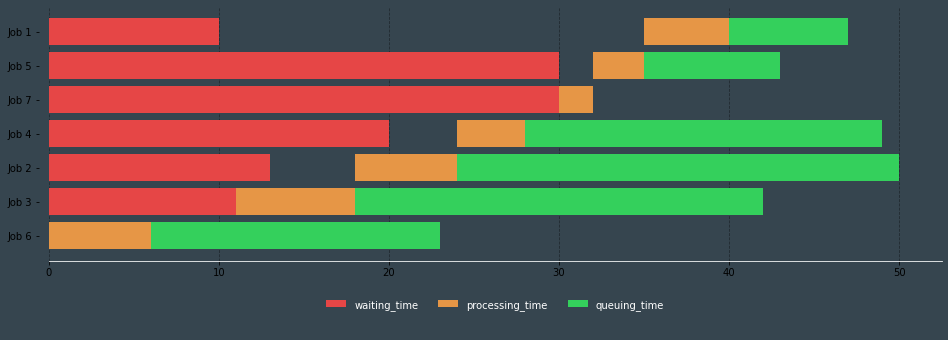

In [30]:
def color(row):
    c_dict = {'waiting_time':'#E64646', 'processing_time':'#E69646', 'queuing_time':'#34D05C'}
    return c_dict[row['legend']]


def visu_calender(N,a,d,q,schedule) :
    '''
    input : N,a,d,q  --> data of the problem
            schedule --> a schedule

    output : matplotlib fig --> use of the function barh
    '''

    N,a,d,q = instance_creation(N,a,d,q)


    # creation of a dataframe
    df = {'task' : [] , 'start_time' : [] , 'end_time' : [] , 'legend' : []}
    curr_time = 0

    for i in range(len(N)) :
        curr_task = schedule[i]
        curr_name = "Job "+str(curr_task)
        


        # waiting period
        df['task'].append(curr_name)
        df['legend'].append("waiting_time")
        df['start_time'].append(0)
        df['end_time'].append(a[curr_task])

        curr_time = max(curr_time , a[curr_task])

        # processing period
        df['task'].append(curr_name)
        df['legend'].append('processing_time')
        df['start_time'].append(curr_time)
        df['end_time'].append(curr_time+d[curr_task])

        


        # queuing period
        df['task'].append(curr_name)
        df['legend'].append('queuing_time')
        df['start_time'].append(curr_time+d[curr_task])
        df['end_time'].append(curr_time+d[curr_task]+q[curr_task])

        curr_time += d[curr_task]

    
    df = pd.DataFrame(df)
    df['color'] = df.apply(color, axis=1)


    # graphic part

    fig, (ax, ax1) = plt.subplots(2, figsize=(16,6), gridspec_kw={'height_ratios':[6, 1]}, facecolor='#36454F')
    ax.set_facecolor('#36454F')
    ax1.set_facecolor('#36454F')


    ax.barh(df.task, df['end_time'] - df['start_time'], left=df.start_time, color=df.color)
    ax.xaxis.grid(color='k', linestyle='dashed', alpha=1, which='both')
    
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='k', linestyle='dashed', alpha=0.4, which='both')

    plt.setp([ax.get_xticklines()], color='w')

    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('w')

    

    ##### LEGENDS #####
    c_dict = {'waiting_time':'#E64646', 'processing_time':'#E69646', 'queuing_time':'#34D05C'}

    legend_elements = [Patch(facecolor=c_dict[i], label=i)  for i in c_dict]
    legend = ax1.legend(handles=legend_elements, loc='upper center', ncol=5, frameon=False)
    plt.setp(legend.get_texts(), color='w')

    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.set_xticks([])
    ax1.set_yticks([])

    return fig






N = list(range(1,8))
a = [10,13,11,20,30,0,30]
d = [5,6,7,4,3,6,2]
q = [7,26,24,21,8,17,0]

schedule = [6, 3, 2, 4, 7, 5, 1] # pulp solution

fig = visu_calender(N,a,d,q , schedule)

### Produce a docx document

We will now try to produce and docx document which sum up all the operations we've donne. This is an exercise that we found interesting because when a professional asks to solve a problem like this one he may not be interested in all the mathematical technicalities behind it. They want the solution in a simple to understand format. That's what we tried to do here.

In [31]:
def creat_doc_data(N,a,d,q) :
    '''
    creation a docx doc --> add just the data to the problem
    '''
    doc = docx.Document() 
  
    doc.add_heading('One machine sequencing problem', 0)
    doc.add_paragraph('Presentation of the data : ')

    data = []

    for i in range(len(N)) :
        job = "Job "+str(N[i])
        row = (job , a[i] , d[i] , q[i])
        data.append(row)
    
    data = tuple(data)

    table = doc.add_table(rows=1, cols=4)
    row = table.rows[0].cells 
    row[0].text = 'Job'
    row[1].text = 'starting_time'
    row[2].text = 'processing_time'
    row[3].text = 'queuing_time'

    for n,start , process,queuing in data: 
  
    
        row = table.add_row().cells 
        row[0].text = n 
        row[1].text = str(start)
        row[2].text = str(process)
        row[3].text = str(queuing)

    table.style = 'Colorful List'

    return doc

In [32]:
def doc_add_shrage_sol(N,a,d,q):
    '''
    add to the previous document, the solution obtained with schrage heurisitc
    '''
    document = creat_doc_data(N,a,d,q)
    
    document.add_page_break()
    document.add_heading('Solve with the Schrage Heuristic', 0)
    solution , fig = solve_schrage_heuristic(N,a,d,q , show_output = False ,graphics = False , larg = 10 , haut = 10)
    schedule = ["Job "+str(i) for i in solution['SCHD']]
    value = solution['UB']
    run_time = solution['time']

    # creation of the table of the solution
    document.add_heading('The raw data : ', 1)
    table = document.add_table(rows=1, cols=2)

    

    row = table.rows[0].cells

    row = table.add_row().cells
    row[0].text = 'Total time'
    row[1].text = str(value)

    row = table.add_row().cells
    row[0].text = "Schedule"
    row[1].text = str(schedule)

    row = table.add_row().cells
    row[0].text = "Running time"
    row[1].text = str(np.round(run_time,3))
    
    table.style = 'Colorful List'

    document.add_heading('The real Schedule', 1)
    fig = visu_calender(N,a,d,q,solution['SCHD'])

    plt.savefig('client_report/buff.png')
    document.add_picture('client_report/buff.png', width=Inches(7))

    return document

In [33]:
def doc_add_mip_sol(N,a,d,q):
    '''
    add to the previous document the solution with the mip
    '''
    document = doc_add_shrage_sol(N,a,d,q)
    
    document.add_page_break()
    document.add_heading('Solve with the Pulp Solver', 0)
    solution = solve_pulp_model(N,a,d,q , show_output = False)
    schedule = ["Job "+str(i) for i in solution['SCHD']]
    value = solution['OBJ']
    run_time = solution['RUN_TIME']

    # creation of the table of the solution
    document.add_heading('The raw data : ', 1)
    table = document.add_table(rows=1, cols=2)

    

    row = table.rows[0].cells

    row = table.add_row().cells
    row[0].text = 'Total time'
    row[1].text = str(value)

    row = table.add_row().cells
    row[0].text = "Schedule"
    row[1].text = str(schedule)

    row = table.add_row().cells
    row[0].text = "Running time"
    row[1].text = str(np.round(run_time,3))
    
    table.style = 'Colorful List'

    document.add_heading('The real Schedule', 1)
    fig = visu_calender(N,a,d,q,solution['SCHD'])

    plt.savefig('client_report/buff.png')
    document.add_picture('client_report/buff.png', width=Inches(7))

    return document

In [34]:
def create_save_doc(N,a,d,q , name = "default") :
    '''
    input : N, a, d, q --> data of the problem
            name       --> name of the document (without the .docx)
    '''
    name += ".docx" # --> docx format for the document
    doc = doc_add_mip_sol(N,a,d,q)
    doc.save("client_report/"+name)
    

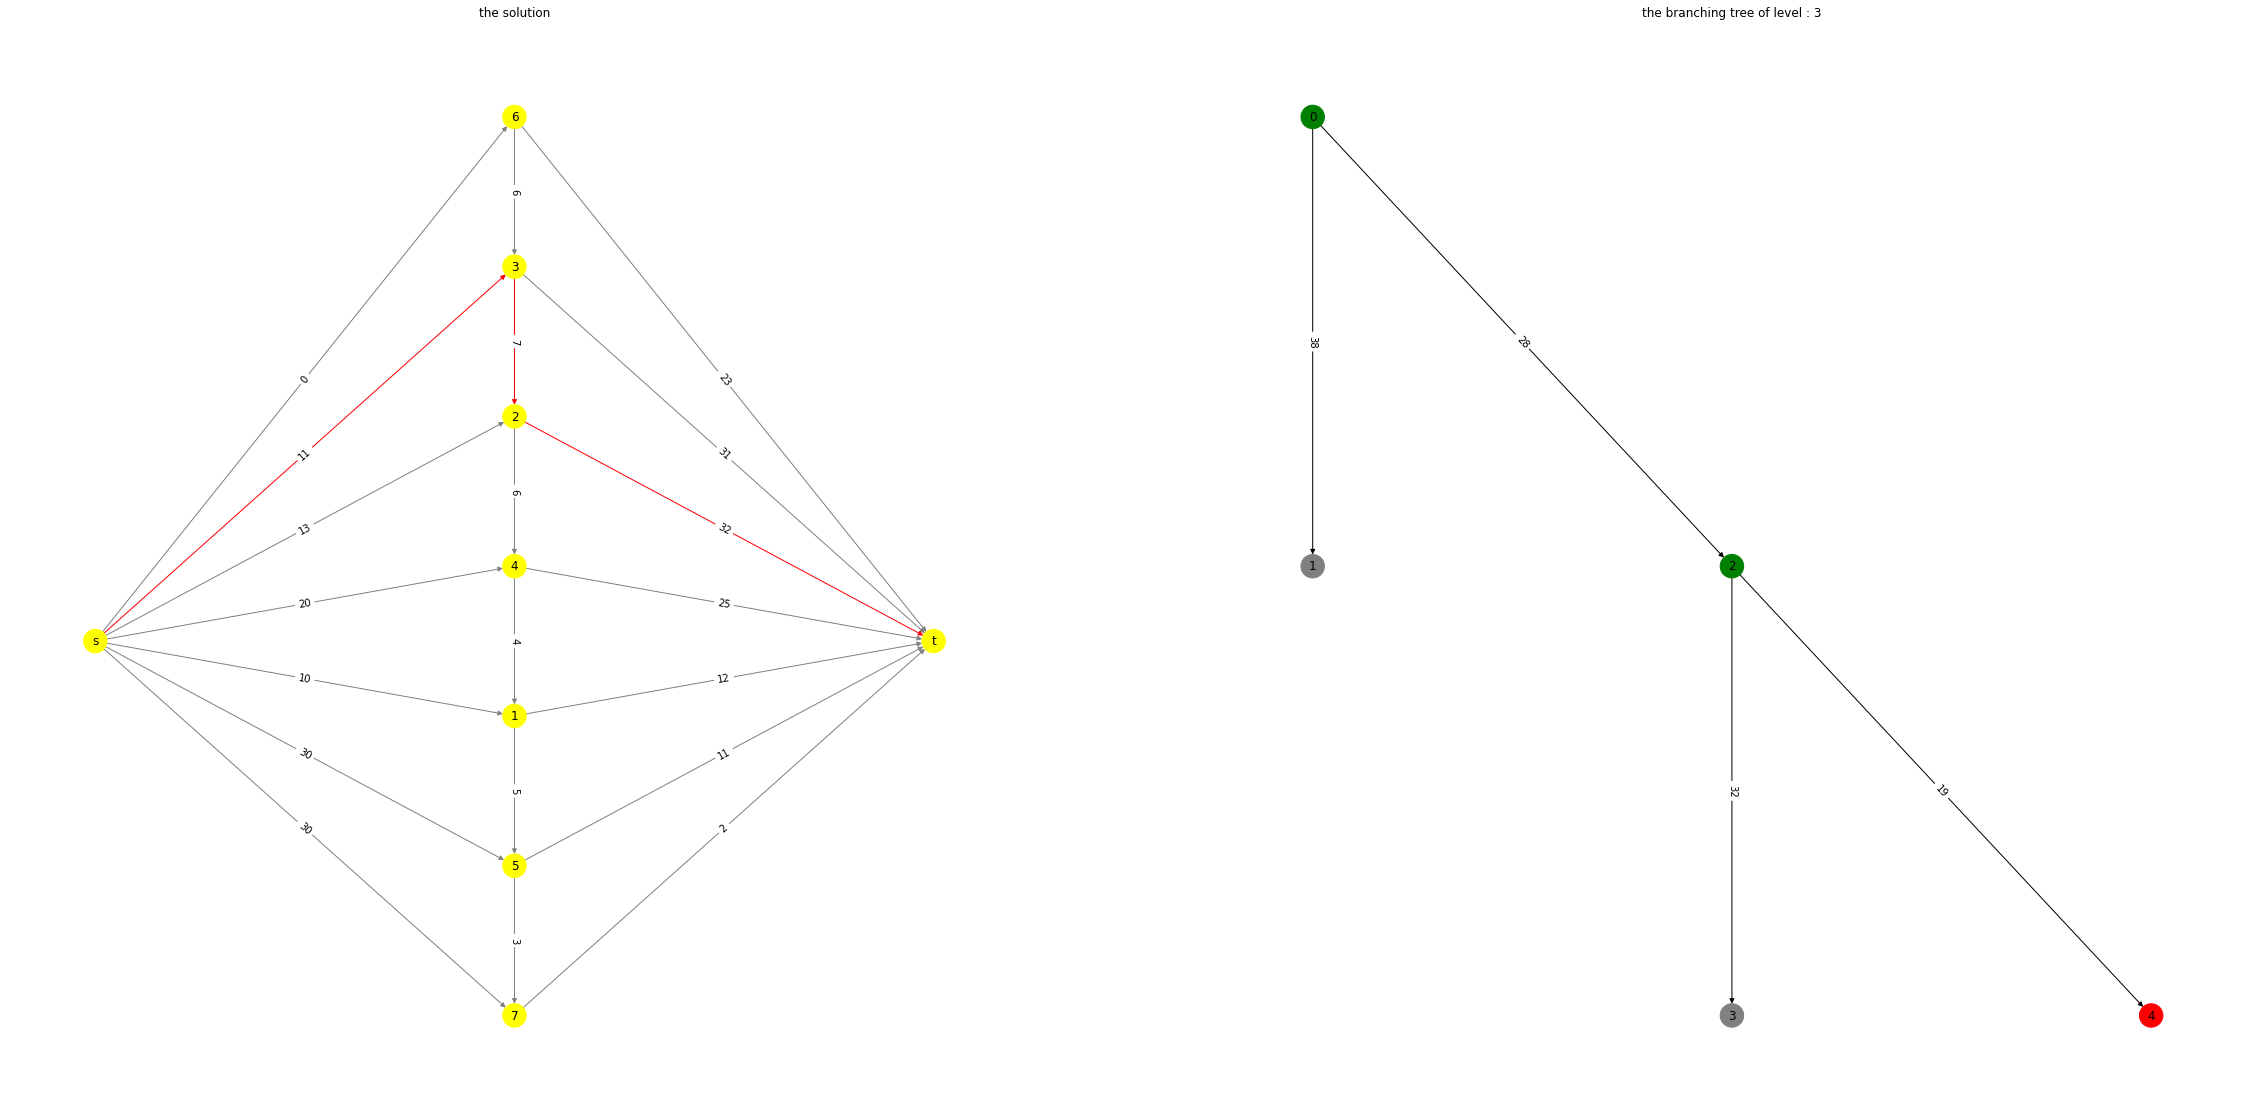

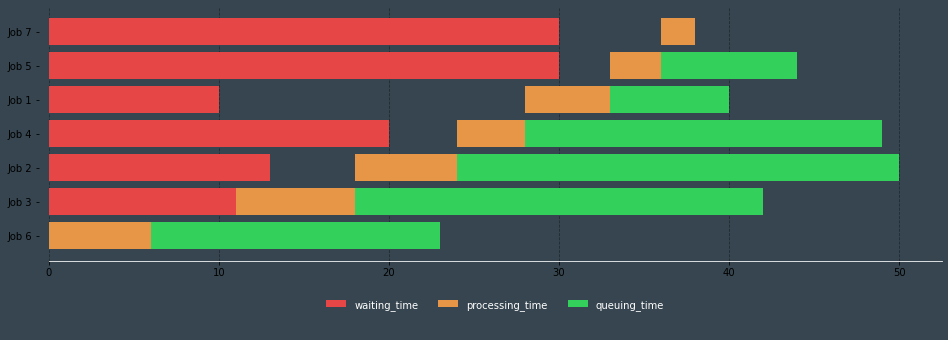

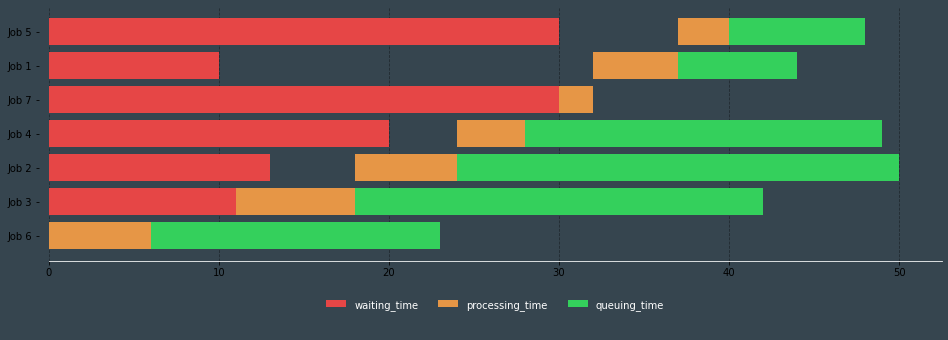

In [35]:
N = list(range(1,8))
a = [10,13,11,20,30,0,30]
d = [5,6,7,4,3,6,2]
q = [7,26,24,21,8,17,0]

create_save_doc(N,a,d,q , "instance_from_the_paper")

## Testing part

### Basic test

At first, in order to carry out tests, we generated instances in a random way. We have to be careful when looking for solutions, because in this problem the solutions are not unique, and it can happen that the programming found by the solver is the same as the one found with Schrage. It is simply necessary to check (on the planning in the form of a calendar), that the critical tasks are the same. There can be inversions in the tasks. Some tasks can swap. These are tasks that do not cause problems in the schedule.

You can run the two following cells with a different value of the seed. The seed 155, gives us a really interesting tree with multiple nodes.

-----Schrage solution -----
schedule [8, 2, 1, 7, 4, 10, 3, 6, 9, 5]
UB :  182
LB :  182


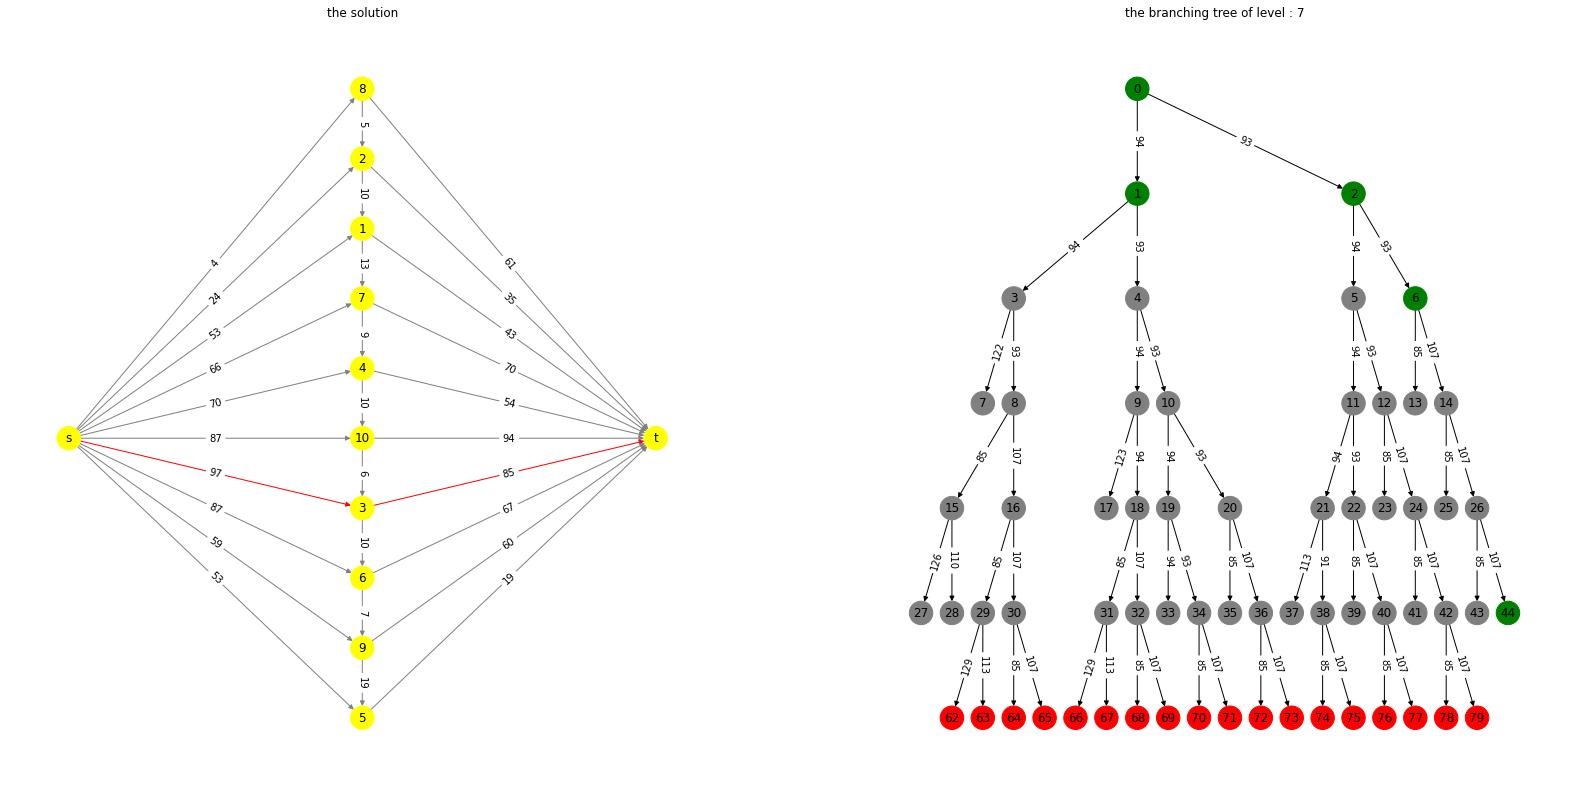

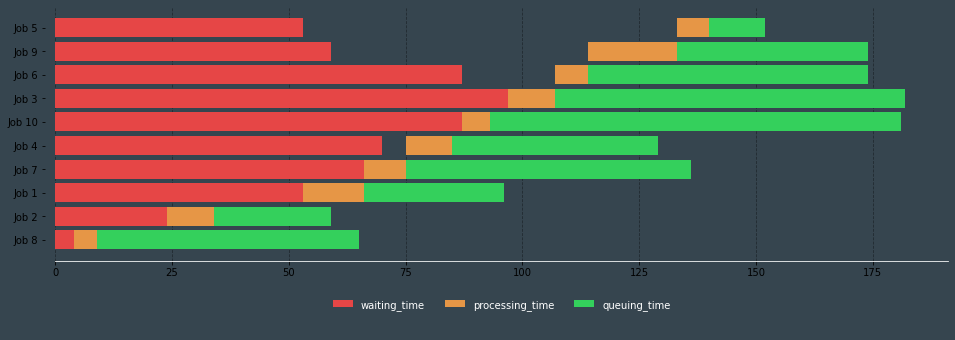

In [36]:
# --> seed to generate the same instance
# --> big tree with this seed.

np.random.seed(155)


# --> instance genration
N,a,d,q = random_instance_default(10 , 20 , 25)

print("-----Schrage solution -----")
# --> The schrage heuristic
solution , fig_schrage = solve_schrage_heuristic(N,a,d,q , show_output = False ,graphics = False , larg = 7 , haut = 7)
schedule = solution['SCHD']
print("schedule", schedule)
print('UB : ',  solution['UB'])
print('LB : ' , solution['LB'])
calender_schrage =  visu_calender(N,a,d,q , schedule)
calender_schrage.show()


----MIP solution---
schedule :  [2, 8, 5, 9, 7, 10, 3, 6, 1, 4]
objective value :  182.0


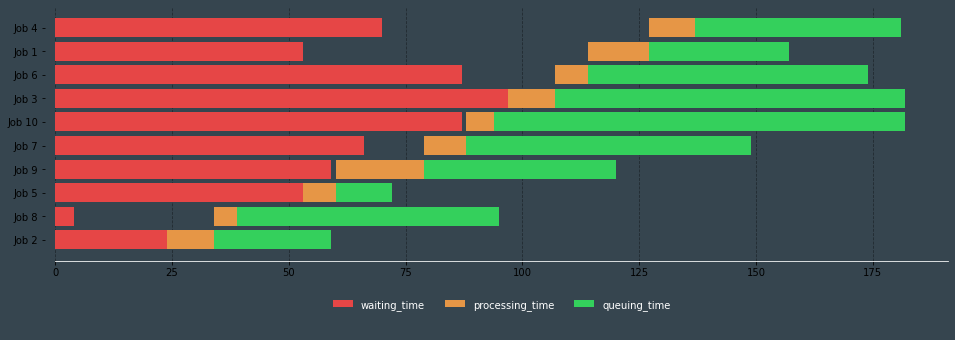

In [37]:
print("----MIP solution---")
# --> MIP solver.
solution = solve_pulp_model(N,a,d,q , show_output = False)
print("schedule : " , solution['SCHD'])
print("objective value : " , solution['OBJ'])
calender_mip = visu_calender(N,a,d,q , solution['SCHD'])

### Advanced Tests

We will now try to produce a large number of different test instances, and compare the results between our programming based on Schrage's Heuristics and the linear program.
We will see on a large number of instances if we have the same solutions as the Pulp solver.

To do this we will create two classes that derive from the exception class, in order to manage the cases where we have differences between the solutions found.

In [44]:
class Diff_results(Exception) :
    '''
    raise an exception when the two modles have different results
    '''
    pass

class Diff_bound(Exception) :
    '''
    raise an exception when the two bounds of the b & b algorithm has different values
    '''
    pass


N = []
a = []
d = []
q = []

N_e = []
a_e = []
d_e = []
q_e = []

nb_comp = 1000 # will run 1000 models et compare the results
tol = 0.001

k = 0
# problem with seed 10
np.random.seed(10)

print("--- Start of the tests ---")

for j in range(nb_comp):
     
    card = randint.rvs(2,5,size = 1)[0] # --> size of the instance
    K = randint.rvs(1,25,size = 1)[0]
    m = randint.rvs(200,300,size = 1)[0]
                               # --> seed for the random instance

    N,a,d,q = random_instance_default(card , m , K)

    

    
    solution_schrage = branch_n_bound(N,a,d,q)
    UB = solution_schrage['UB']
    LB = solution_schrage['LB']

    solution_mip =  solve_pulp_model(N,a,d,q , show_output = False)
    mip_B = solution_mip['OBJ']

    try :

        k += 1

        if (np.abs(UB-mip_B)>tol):
            raise Diff_results
            



    except Diff_results :
        N_e = N
        a_e = a
        d_e = d
        q_e = q 


        k -= 1
        print("Not the same results")
        print("\t UB : ", UB)
        print("\t MIP_B : ",mip_B)
        
        try :
            if (np.abs(UB-LB)> tol) :
                raise Diff_bound

        except Diff_bound :
            print("\t mip : ", solution_mip['SCHD'])
            print("\t schrage : ",solution_schrage['SCHD'])
            print("\t Tree length : " , len(solution_schrage['Tree']))


print("--- end of the test ---")
if (k == nb_comp):
    '''
    There was no problems.
    '''
    print("Clear !")

else :
    print("There was {} bad results ".format(nb_comp - k))


--- Start of the tests ---
--- end of the test ---
Clear !


In [48]:
print("--- Start of the tests ---")
k = 0
for j in range(10):
    print(j)
     
    card = randint.rvs(2,5,size = 1)[0] # --> size of the instance
    K = randint.rvs(1,25,size = 1)[0]
    m = randint.rvs(200,300,size = 1)[0]
                               

    N,a,d,q = random_instance_default(10 , m , K)

    

    
    solution_schrage = branch_n_bound(N,a,d,q)
    UB = solution_schrage['UB']
    LB = solution_schrage['LB']

    solution_mip =  solve_pulp_model(N,a,d,q , show_output = False)
    mip_B = solution_mip['OBJ']

    try :

        k += 1

        if (np.abs(UB-mip_B)>tol):
            raise Diff_results
            



    except Diff_results :
        N_e = N
        a_e = a
        d_e = d
        q_e = q 


        k -= 1
        print("Not the same results")
        print("\t UB : ", UB)
        print("\t MIP_B : ",mip_B)
        
        try :
            if (np.abs(UB-LB)> tol) :
                raise Diff_bound

        except Diff_bound :
            print("\t mip : ", solution_mip['SCHD'])
            print("\t schrage : ",solution_schrage['SCHD'])
            print("\t Tree length : " , len(solution_schrage['Tree']))


print("--- end of the test ---")
if (k == 10):
    '''
    There was no problems.
    '''
    print("Clear !")

else :
    print("There was {} bad results ".format(nb_comp - k))

--- Start of the tests ---
0
1
2
3


KeyboardInterrupt: 

Nous avons ainsi réaliser un ensemble de test, sur des instances de tailles très différentes avec des valeurs très différentes. Cette section nous permet ainsi de conclure quand à la validité de notre algorithme.

-----Schrage solution -----
schedule [1, 0, 5, 3, 2, 6, 4]
UB :  416
LB :  416


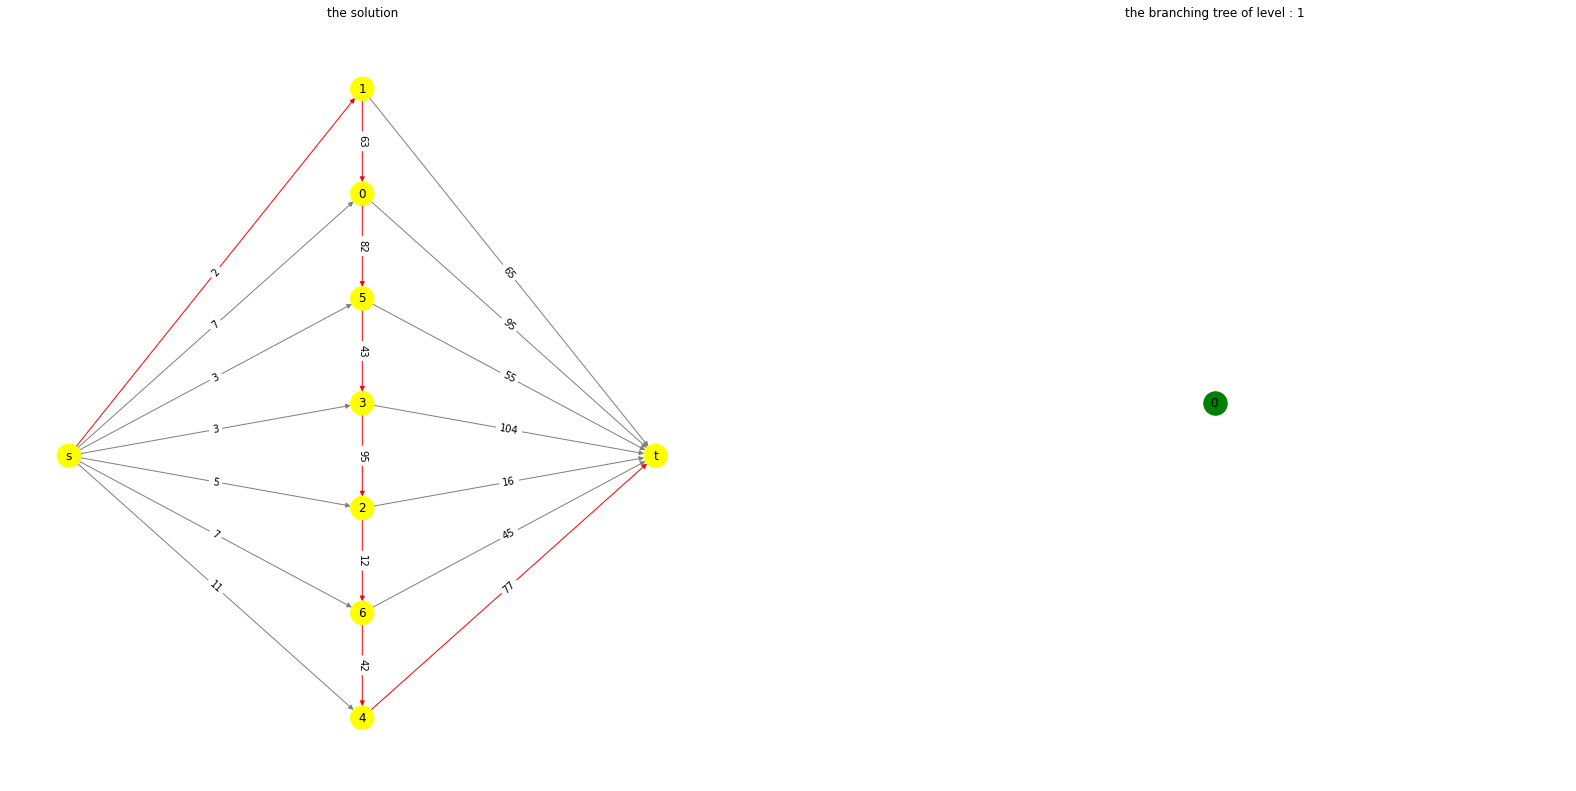

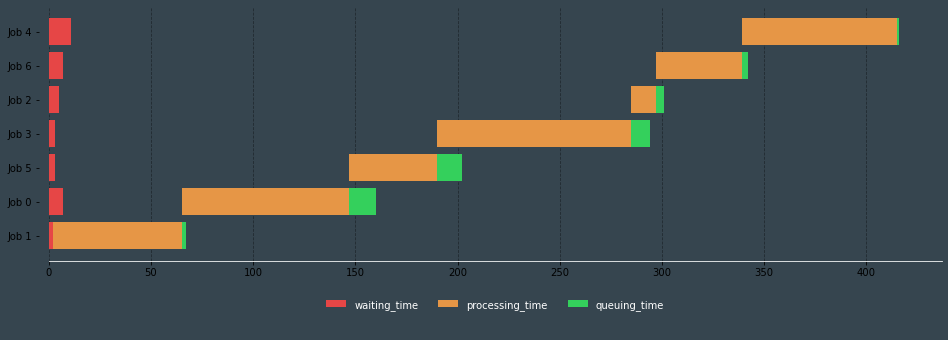

In [38]:
test = {'a': np.array([ 7,  2,  5,  3, 11,  3,  7]),
 'd': np.array([82, 63, 12, 95, 76, 43, 42]),
 'q': np.array([13,  2,  4,  9,  1, 12,  3])}

a = test['a']
d = test['d']
q = test['q']
N = list(range(len(a)))

print("-----Schrage solution -----")
# --> The schrage heuristic
solution , fig_schrage = solve_schrage_heuristic(N,a,d,q , show_output = False ,graphics = False , larg = 7 , haut = 7)
schedule = solution['SCHD']
print("schedule", schedule)
print('UB : ',  solution['UB'])
print('LB : ' , solution['LB'])
calender_schrage =  visu_calender(N,a,d,q , schedule)
calender_schrage.show()


----MIP solution---
schedule :  [1, 3, 6, 2, 0, 5, 4]
objective value :  416.0


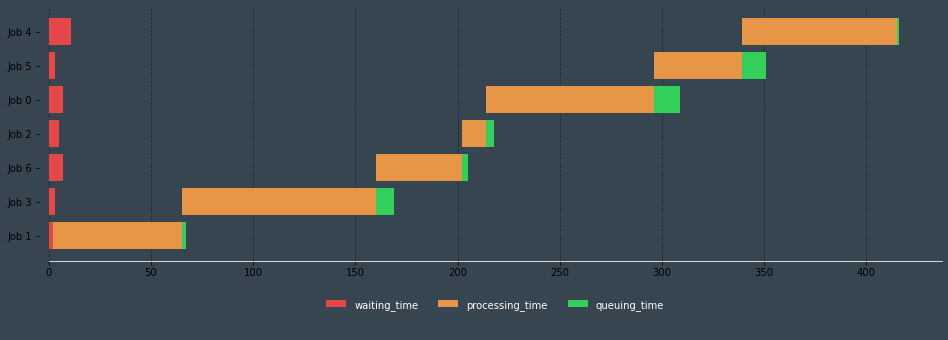

In [39]:
print("----MIP solution---")
# --> MIP solver.
solution = solve_pulp_model(N,a,d,q , show_output = False)
print("schedule : " , solution['SCHD'])
print("objective value : " , solution['OBJ'])
calender_mip = visu_calender(N,a,d,q , solution['SCHD'])

## Calculus time 

In this section we will compare the computation time between our solution based on the schrage heuristic, and the solution found from the solver used in the Pulp library. This solver also uses a branch and bound algorithm but based on cutting planes. This solver is generic and allows to approach any problem expressed in the form of integer linear programming. Our solution uses the form of the problem. We thus expect our solution to be faster in terms of computation time.

In [51]:
map_runtime_shrage = {}
map_runtime_mip = {}

np.random.seed(1)

for i in range(2,10):
    map_runtime_shrage[i] = []
    map_runtime_mip[i] = []


for i in range(2,10):
    print(i)
    # --> we'll compute several instance of length i
    for k in range(100):
        K = randint.rvs(1,25,size = 1)[0]
        m = randint.rvs(200,300,size = 1)[0]
                              

        N,a,d,q = random_instance_default(i , m , K)

        start = time()
        solution_shrage = branch_n_bound(N , a , d , q)
        end = time()-start
        map_runtime_shrage[i].append(end)

        solution_mip =  solve_pulp_model(N,a,d,q , show_output = False)
        map_runtime_mip[i].append(solution_mip['RUN_TIME'])
        

2
3
4
5
6
7
8
9


## The Tree hight

Nous allons maintenant faire une étude de l'arbre de branchement, que nous réalisons avec la programmation de shrage. Nous allons essayer de venir comprendre comment la taille de l'arbre évolue, en fonction de la taille de l'instance que nous lui donnons. 

In [153]:
# --> get the size of the tree

def get_size(Tree) :
    '''
    input : Tree --> python array of node

    output : the size of the tree
    '''
    return max([t._level for t in solution['Tree']])


Script python pour générer plusieurs instances et venir moyenner les résultats obtenus

In [164]:
dist_hight = {}
n_range = list(range(2,25)) # --> start with this range (first obsrvations)
num = 1000


for n in n_range :
    dist_hight[n] = []

for n in n_range :
    print(n)

    for j in range(1,num+1) :

        np.random.seed(j)
        N,a,d,q = random_instance_default(n , 20 , 25)
        solution  = branch_n_bound(N , a , d , q , msg = 0)
        Tree = solution['Tree']

        dist_hight[n].append(get_size(Tree))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


No handles with labels found to put in legend.


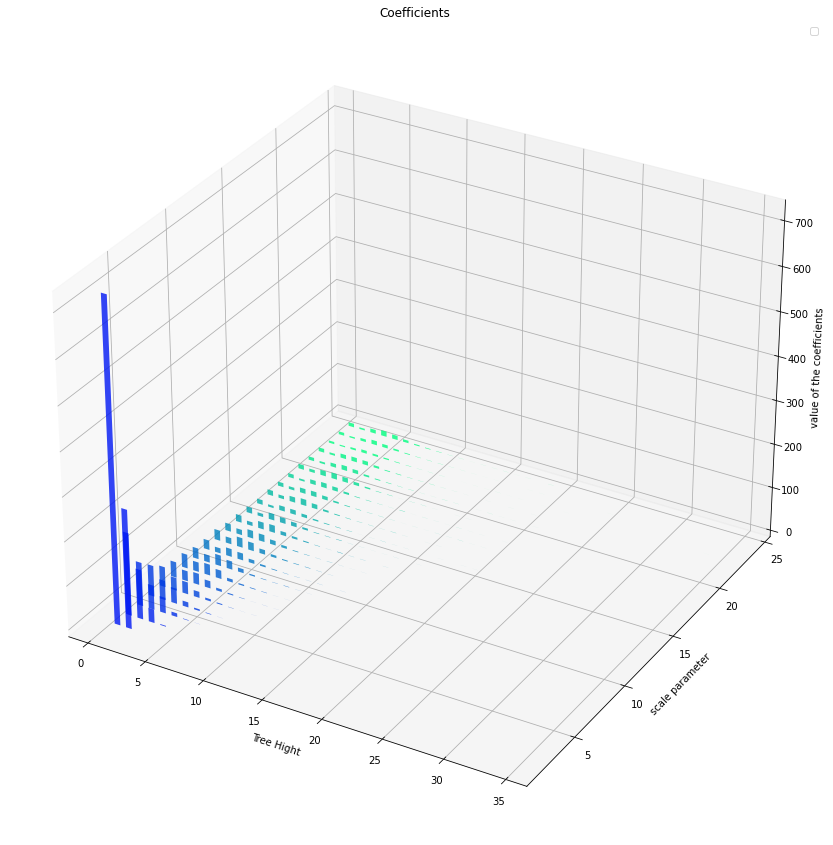

In [166]:
# --> graphique representations 

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
nbins = 70
p = np.linspace(0,len(dist_hight)-1 , len(dist_hight)-1)

k = 1

visu = list(range(2,25))

for n in dist_hight :

    if n in visu:
        z = n
        c = cm.winter(n/len(p))

        hist , bins = np.histogram(dist_hight[n] , density = True , bins = len(dist_hight[n]))

        xs =  (bins[:-1] + bins[1:])/2

        cs = [c]*len(xs)

        ax.bar(xs, 
                hist, 
                zs=z, 
                zdir='y',
                color=cs,
                alpha = 0.8,
                width = 0.5)

        k = k+1


    

ax.set_xlabel('Tree Hight')
ax.set_ylabel('scale parameter')
ax.set_zlabel('value of the coefficients')
ax.set_title('Coefficients')
ax.legend()
plt.show()

